In [1]:
import tensorflow as tf
import pandas as pd
import zipfile, os, shutil
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm as tq
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# Cek Versi Tensorflow
print(tf.__version__)

2.4.1


In [3]:
# Download Dataset Katarak
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download jr2ngb/cataractdataset
! chmod 600 kaggle.json
! ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle
! kaggle datasets download jr2ngb/cataractdataset

100% 3.34G/3.34G [00:54<00:00, 53.6MB/s]
100% 3.34G/3.34G [00:54<00:00, 66.4MB/s]
cataractdataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
# Proses Ekstrak Dataset
with zipfile.ZipFile('cataractdataset.zip','r') as z:
  z.extractall('./')

os.listdir()

['.config',
 'dataset',
 'repository',
 'cataractdataset.zip',
 'README.md',
 'sample_data']

In [5]:
# Hapus Direktori yang Tidak Digunakan
dir_path = '/content/repository'

shutil.rmtree(dir_path)

In [6]:
base_dir = '/content/dataset'

file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(base_dir):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [7]:
# Menerapkan Fungsi Callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.65 and logs.get('val_accuracy')>0.65):
            print("\nAkurasi telah mencapai lebih dari 65%, proses dihentikan!")
            self.model.stop_training = True

In [8]:
# Proses Split Dataset
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

X = df['path']
y = df['tag']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=300)

df_tr = pd.DataFrame({'path':X_train, 'tag':y_train, 'set':'train'})
df_val = pd.DataFrame({'path':X_val, 'tag':y_val, 'set':'validation'})

print('train size', len(df_tr))
print('val size', len(df_val))

df_all = df_tr.append([df_val]).reset_index(drop=1)
print(df_all.groupby(['set','tag']).size(),'\n')

df_all.sample(3)

train size 540
val size 61
set         tag             
train       1_normal            272
            2_cataract           92
            2_glaucoma           89
            3_retina_disease     87
validation  1_normal             28
            2_cataract            8
            2_glaucoma           12
            3_retina_disease     13
dtype: int64 



,path,tag,set
99,/content/dataset/2_cataract/cataract_021.png,2_cataract,train
566,/content/dataset/2_cataract/cataract_033.png,2_cataract,validation
76,/content/dataset/1_normal/NL_283.png,1_normal,train


In [9]:
datasource_path = base_dir
dataset_path = "content/dataset/dataset/"

for index, row in tq(df_all.iterrows()):
    
    #detect filepath
    file_path = row['path']            
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])  
    
    #make folder destination dirs
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))
    
    #define file dest
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)
    
    #copy file from source to dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

In [10]:
# Image Augmentation
train_dir = "content/dataset/dataset/train"
val_dir = "content/dataset/dataset/validation"

train_datagen = ImageDataGenerator(
                  rescale=1./255,
                  rotation_range=40,
                  vertical_flip=True,
                  shear_range = 0.2,
                  zoom_range=0.2,
                  fill_mode = 'nearest')

val_datagen = ImageDataGenerator(
                  rescale=1./255,
                  rotation_range=40,
                  vertical_flip=True,
                  shear_range = 0.2,
                  zoom_range=0.2,
                  fill_mode = 'nearest')

train_generator = train_datagen.flow_from_directory(
        train_dir,  # direktori data latih
        target_size=(150,150),          
        class_mode='categorical')
 
validation_generator = val_datagen.flow_from_directory(
        val_dir, # direktori data validasi
        target_size=(150, 150), 
        class_mode='categorical')

Found 540 images belonging to 4 classes.
Found 61 images belonging to 4 classes.


In [11]:
# Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [14]:
callbacks = myCallback()
history = model.fit(
    train_generator,
    steps_per_epoch = 15,
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = 2,
    verbose =1,
    callbacks=[callbacks]
)

Epoch 1/30
15/15 [==============================] - 59s 4s/step - loss: 1.2676 - accuracy: 0.5042 - val_loss: 1.2897 - val_accuracy: 0.4590
Epoch 2/30
15/15 [==============================] - 56s 4s/step - loss: 1.2869 - accuracy: 0.5105 - val_loss: 1.3040 - val_accuracy: 0.4590
Epoch 3/30
15/15 [==============================] - 56s 4s/step - loss: 1.2487 - accuracy: 0.5126 - val_loss: 1.2652 - val_accuracy: 0.4590
Epoch 4/30
15/15 [==============================] - 56s 4s/step - loss: 1.2524 - accuracy: 0.5042 - val_loss: 1.2875 - val_accuracy: 0.4590
Epoch 5/30
15/15 [==============================] - 57s 4s/step - loss: 1.2658 - accuracy: 0.4748 - val_loss: 1.2853 - val_accuracy: 0.4590
Epoch 6/30
15/15 [==============================] - 57s 4s/step - loss: 1.2346 - accuracy: 0.5105 - val_loss: 1.2666 - val_accuracy: 0.4590
Epoch 7/30
15/15 [==============================] - 56s 4s/step - loss: 1.2181 - accuracy: 0.5105 - val_loss: 1.2264 - val_accuracy: 0.4754
Epoch 8/30
15/15 [==

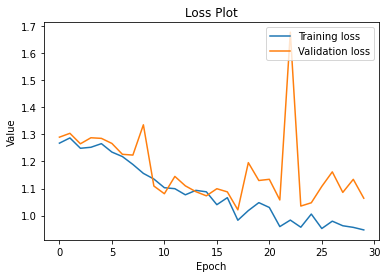

In [16]:
# Grafik untuk Loss Train dan Loss Validation..
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], label ='Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

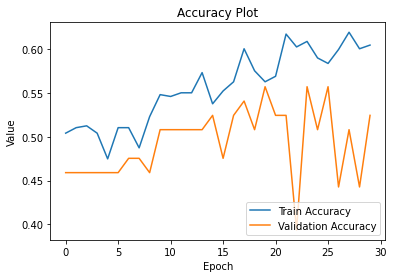

In [17]:
# Grafik untuk Akurasi Train dan Akurasi validation..
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [22]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  if classes[0,0]!=0:
    print('this is a normal')
  elif classes[0,1]!=0:
    print('this is a cataract')
  elif classes[0,2]!=0:
    print('this is a glaucoma')    
  else:
    print('this is a eye disease')

Saving tes.png to tes.png
tes.png
this is a eye disease


In [ ]:
# Konversi model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpjwfme2dn/assets
